In [4]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.7/884.7 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.8/121.8 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 53.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.4/223.4 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.

In [221]:
import torch
import numpy as np
import pandas as pd
import shutil

from darts.models import TiDEModel
from darts.dataprocessing.transformers.scaler import Scaler
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from darts.metrics import mae, mse

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [222]:
optimizer_kwargs = {
    "lr": 1e-3,
}

# PyTorch Lightning Trainer arguments
pl_trainer_kwargs = {
    "gradient_clip_val": 1,
    "max_epochs": 200,
    "accelerator": "auto",
    "callbacks": [],
}

# learning rate scheduler
lr_scheduler_cls = torch.optim.lr_scheduler.ExponentialLR
lr_scheduler_kwargs = {
    "gamma": 0.999,
}

# early stopping (needs to be reset for each model later on)
# this setting stops training once the the validation loss has not decreased by more than 1e-3 for 10 epochs
early_stopping_args = {
    "monitor": "val_loss",
    "patience": 10,
    "min_delta": 1e-3,
    "mode": "min",
}

#
common_model_args = {
    "input_chunk_length": 12,  # lookback window
    "output_chunk_length": 12,  # forecast/lookahead window
    "optimizer_kwargs": optimizer_kwargs,
    "pl_trainer_kwargs": pl_trainer_kwargs,
    "lr_scheduler_cls": lr_scheduler_cls,
    "lr_scheduler_kwargs": lr_scheduler_kwargs,
    "likelihood": None,  # use a likelihood for probabilistic forecasts
    "save_checkpoints": True,  # checkpoint to retrieve the best performing model state,
    "force_reset": True,
    "batch_size": 256,
    "random_state": 42,
}

In [223]:
file_path = '/content/halong_quality.csv'
series = pd.read_csv(file_path)

In [224]:
PM25_df = series[['date', 'pm25']]

In [225]:
PM25_df['date'] = pd.to_datetime(PM25_df['date'])
time_series = TimeSeries.from_dataframe(PM25_df, 'date', 'pm25')

In [226]:
time_series

<TimeSeries (DataArray) (date: 1828, component: 1, sample: 1)>
array([[[ 6.]],

       [[59.]],

       [[43.]],

       ...,

       [[39.]],

       [[64.]],

       [[ 5.]]])
Coordinates:
  * date       (date) datetime64[ns] 2019-03-01 2019-03-02 ... 2024-03-01
  * component  (component) object 'pm25'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [227]:
from datetime import datetime, timedelta

# Ngày bắt đầu và kết thúc
start_date = datetime(2019, 3, 1)
end_date = datetime(2024, 3, 1)

# Tính tổng số ngày
total_days = (end_date - start_date).days

# Tính số ngày cho tập huấn luyện và tập test
train_days = int(total_days * 7 / 10)
test_days = total_days - train_days

# Tính ngày kết thúc của tập huấn luyện và ngày bắt đầu của tập test
train_end_date = start_date + timedelta(days=train_days)
test_start_date = train_end_date + timedelta(days=1)

print("Ngày kết thúc của tập huấn luyện:", train_end_date.strftime("%d/%m/%Y"))
print("Ngày bắt đầu của tập test:", test_start_date.strftime("%d/%m/%Y"))


Ngày kết thúc của tập huấn luyện: 30/08/2022
Ngày bắt đầu của tập test: 31/08/2022


In [228]:
# train_end_date = pd.Timestamp(train_end_date)

In [267]:
time_series

<TimeSeries (DataArray) (date: 1828, component: 1, sample: 1)>
array([[[ 6.]],

       [[59.]],

       [[43.]],

       ...,

       [[39.]],

       [[64.]],

       [[ 5.]]])
Coordinates:
  * date       (date) datetime64[ns] 2019-03-01 2019-03-02 ... 2024-03-01
  * component  (component) object 'pm25'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [302]:
train, test = time_series.split_after(0.7)

In [303]:
train

<TimeSeries (DataArray) (date: 1279, component: 1, sample: 1)>
array([[[ 6.]],

       [[59.]],

       [[43.]],

       ...,

       [[13.]],

       [[51.]],

       [[27.]]])
Coordinates:
  * date       (date) datetime64[ns] 2019-03-01 2019-03-02 ... 2022-08-30
  * component  (component) object 'pm25'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [304]:
test

<TimeSeries (DataArray) (date: 549, component: 1, sample: 1)>
array([[[ 24.]],

       [[ 29.]],

       [[  5.]],

       [[ 55.]],

       [[ 42.]],

       [[ 43.]],

       [[ 10.]],

       [[ 88.]],

       [[ 68.]],

       [[ 30.]],

...

       [[ 48.]],

       [[ 16.]],

       [[  5.]],

       [[ 72.]],

       [[ 34.]],

       [[ 43.]],

       [[ 24.]],

       [[ 39.]],

       [[ 64.]],

       [[  5.]]])
Coordinates:
  * date       (date) datetime64[ns] 2022-08-31 2022-09-01 ... 2024-03-01
  * component  (component) object 'pm25'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

<Axes: xlabel='date'>

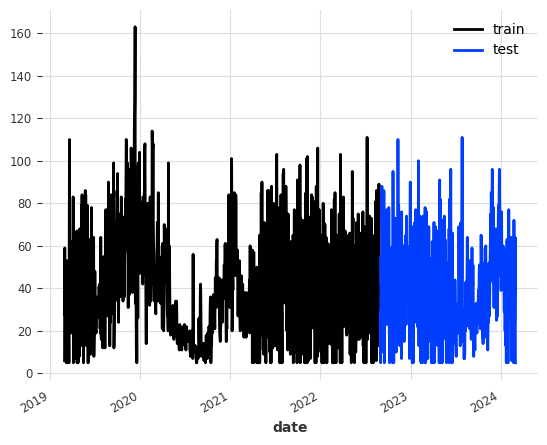

In [305]:
train.plot(label="train")
test.plot(label="test")

In [306]:
scaler = Scaler()  # default uses sklearn's MinMaxScaler
train = scaler.fit_transform(train)
test = scaler.transform(test)

In [307]:

model_tide = TiDEModel(
    **common_model_args, use_reversible_instance_norm=False, model_name="tide0"
)

model_tide_rin = TiDEModel(
    **common_model_args, use_reversible_instance_norm=True, model_name="tide1"
)

models = {
    "TiDE": model_tide,
    "TiDE+RIN": model_tide_rin,
}

In [311]:
# train the models and load the model from its best state/checkpoint
for name, model in models.items():

    # early stopping needs to get reset for each model
    pl_trainer_kwargs["callbacks"] = [
        EarlyStopping(
            **early_stopping_args,
        )
    ]

    model.fit(
        series=train,
        val_series=val,
        verbose=False,
    )
    # load from checkpoint returns a new model object, we store it in the models dict
    models[name] = model.load_from_checkpoint(model_name=model.model_name, best=True)

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

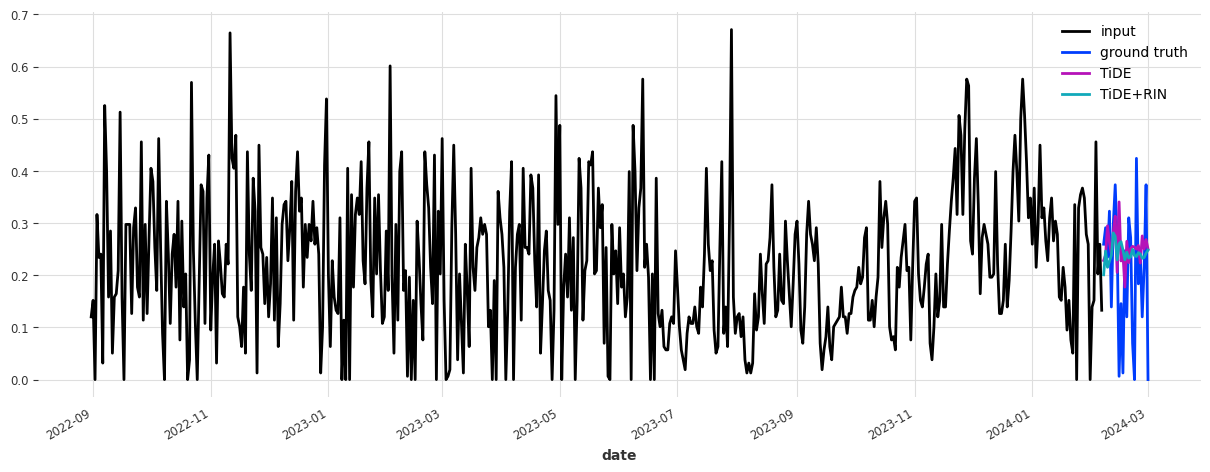

In [314]:
# we will predict the next `pred_steps` points after the end of `pred_input`
pred_steps = common_model_args["output_chunk_length"] * 2
pred_input = test[:-pred_steps]

fig, ax = plt.subplots(figsize=(15, 5))
pred_input.plot(label="input")
test[-pred_steps:].plot(label="ground truth", ax=ax)

result_accumulator = {}
# predict with each model and compute/store the metrics against the test sets
for model_name, model in models.items():
    pred_series = model.predict(n=pred_steps, series=pred_input)
    pred_series.plot(label=model_name, ax=ax)

    result_accumulator[model_name] = {
        "mae": mae(test, pred_series),
        "mse": mse(test, pred_series),
    }

<Axes: >

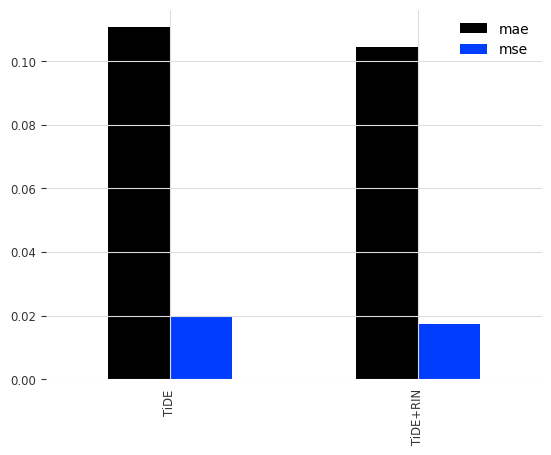

In [315]:
results_df = pd.DataFrame.from_dict(result_accumulator, orient="index")
results_df.plot.bar()